<a href="https://colab.research.google.com/github/wendianaxu/speech-emotion-recognition/blob/main/speech_emotion_recognition_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will demonstrate how we trained our models for speech emotion recognition and their performance on test data.

# Data Preprocessing
In this section, we will run through how we extracted features from our dataset and prepared them for training. 

In [ ]:
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/wendianaxu/speech-emotion-recognition.git

Cloning into 'speech-emotion-recognition'...
remote: Enumerating objects: 1562, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 1562 (delta 38), reused 50 (delta 15), pack-reused 1469
Receiving objects: 100% (1562/1562), 214.12 MiB | 25.02 MiB/s, done.
Resolving deltas: 100% (277/277), done.
Updating files: 100% (1457/1457), done.


In [ ]:
# copy directory to drive
!cp -r "/content/speech-emotion-recognition" "/content/drive/MyDrive"

^C


We used the Librosa library to extract MFCC features from audio files. In our first attempt, we chose to have 13 MFCC features because it is a common choice for speech recognition models.

In [ ]:
# test: load an audio file, extract mfccs, and visualize

test_file = "/content/drive/MyDrive/speech-emotion-recognition/RAVDESS_data/Actor_01/03-01-01-01-01-02-01.wav"
n_mfcc = 13 # number of mfcc features
sr = 22050 # sampling rate

audio, sampling_rate = librosa.load(test_file, sr=sr, duration=None) # load an audio file
test_mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc) # extract MFCC features

We can visualize the MFCC features of an audio file with the graph below. Each row represents one MFCC feature and the columns represent time frames.

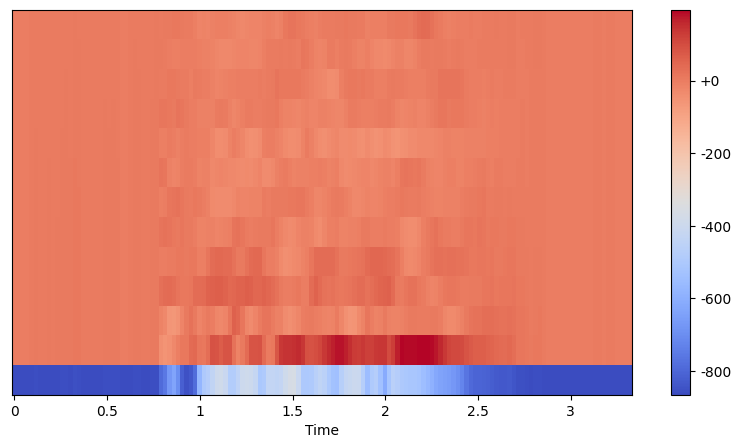

In [ ]:
# visualize mfccs
plt.figure(figsize=(10, 5))
librosa.display.specshow(test_mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

Next, we built a function that can be called iteratively to load all audio files in our folder. 

We processed our data in two different ways:

- The first way is to create a 1D array with MFCC features averaged across the entire duration of the audio. 
- The second way is to have a 2D array with MFCC features varying across time.

In creating the 2D array, because there are moments when the person is not speaking, we used `librosa.effects.trim` to trim out silent moments from the audio. This would help us unify the size of the matrices and reduce irrelevant features. 

We also experimented with using either 13 or 30 MFCC features in the matrix.

In [ ]:
# function for loading an audio file
data_path = "/content/drive/MyDrive/speech-emotion-recognition/RAVDESS_data/"

def load_file(path, dimension = 1, n_mfcc = 13):
  '''
  Load one audio file and return a 1D array containing its mfccs averaged across time or a 2D array with mfccs and time
  '''
  audio, sampling_rate = librosa.load(path, sr=sr, duration=None)
  if dimension == 2:
    # trim out silent moments from the audio
    audio, index = librosa.effects.trim(audio, top_db=20, frame_length=512, hop_length=512)

  mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc) # extract MFCC matrix (cols = coefficients, rows = time)

  if dimension == 1:
    mfccs = np.mean(mfccs.T, axis=0)  # condense MFCC matrix into 1D array, averaging each coefficient across time

  return mfccs

print("Shape of 1D array: ", load_file(test_file, 1).shape)
print("Shape of 2D array: ", load_file(test_file, 2).shape) 

Shape of 1D array:  (13,)
Shape of 2D array:  (13, 53)


The trimmed sounds have different lengths, so we found out the maximum length of trimmed data and defined a function to pad all MFCC matrices to the maximum length.

In [ ]:
# find out the max time length of trimmed audio files
def find_max_len(path):
  max_len = 0 # max duration of trimmed data
  for folder in os.listdir(path): # each folder = one actor
      for file in os.listdir(os.path.join(path, folder)):
          if file.endswith('.wav'):
              file_path = os.path.join(path, folder, file)
              features = load_file(file_path)
              features_len = features.shape[1]
              if max_len < features_len:
                max_len = features_len
  return max_len

In [ ]:
max_len = 0
max_len = find_max_len(data_path)
max_len

144

In [ ]:
# unify the sizes of all feature matrices to (n_mfccs, max_len)
def unify_size(max_len, mfccs):
  '''
  Pad all mfcc matrices to max_len
  '''
  # unify sizes
  if max_len > mfccs.shape[1]: # pad matrices that are shorter than max_len
    pad_width = max_len - mfccs.shape[1]
    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

  return mfccs

Then, we iterated through all files in our dataset and created a matrix `X` with 13 MFCCs as 1D features, a matrix `X_more_mfcc` with 30 MFCCs as 1D features, a matrix `X_2d` with 2D features, and a matrix `y` with all the emotion labels, labelled as integers.

In [ ]:
def preprocess_data(path, dimension = 1, n_mfcc = 13):
  '''
  Preprocess data in all folders within the dataset. 
  '''
  X = []
  y = []
  for folder in os.listdir(path): # each folder = one actor
      for file in os.listdir(os.path.join(path, folder)):
          if file.endswith('.wav'):
              emotion = file.split('-')[2] # get emotion labels
                  
              file_path = os.path.join(path, folder, file)
              features = load_file(file_path, dimension, n_mfcc)
              if (dimension == 2):
                features = unify_size(max_len, features)
              X.append(features)
              y.append(int(emotion))
  return np.array(X), np.array(y)

In [ ]:
# 1D features, 13 mfccs
X, y = preprocess_data(data_path, 1)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (1440, 13)
Shape of y: (1440,)


In [ ]:
# 1D features, 30 mfccs
X_more_mfcc, y = preprocess_data(data_path, 1, 30)
print("Shape of X:", X_more_mfcc.shape)
print("Shape of y:", y.shape)

Shape of X: (1440, 30)
Shape of y: (1440,)


In [ ]:
# 2D features, 30 mfccs
X_2d, y = preprocess_data(data_path, 2, 30)
print("Shape of X:", X_2d.shape)
print("Shape of y:", y.shape)

Shape of X: (1440, 30, 144)
Shape of y: (1440,)


In [ ]:
# one-hot encode labels
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder()

y = np.array(y).reshape(-1,1)
y = OHE.fit_transform(y).toarray()

Finally, we did a train-test split with a 8:2 train-to-test ratio.

In [ ]:
# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

# Data Exploration
In this section, we did some preliminary data exploration to visualize the MFCC values for different emotions based one statement, given that thee intensity, repetition, and actor are all same.

In [ ]:
# function that visualizes different emotions for one statement, given that intensity, repetition, and actor are all same
def visualize_by_statement(path, intensity='01', repetition='01', actor='01'):
    emo = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised', 'UNK']
    color_arr = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta']
    x_values = range(n_mfcc)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for file in os.listdir(os.path.join(path, 'Actor_'+ actor)):
        if file.split('-')[3] == intensity and file.split('-')[5] == repetition:
            emotion = file.split('-')[2]  # get emotion label
            mfcc = load_file(os.path.join(path, 'Actor_'+ actor, file))

            # Plot all emotions in both subplots
            for ax in axes:
                ax.scatter(x_values, mfcc, color=color_arr[int(emotion) - 1], label=emo[int(emotion) - 1])

    for i, ax in enumerate(axes):
        # ax.set_title(f'Subplot {i+1}')
        ax.set_xlabel('Features')
        ax.set_ylabel('MFCC Values')

        if i == 0:
            ax.set_ylim(-800, 100)
        else:
            ax.set_ylim(-20, 40)

        # Remove duplicate labels from the legend
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())

    plt.tight_layout()
    plt.show()

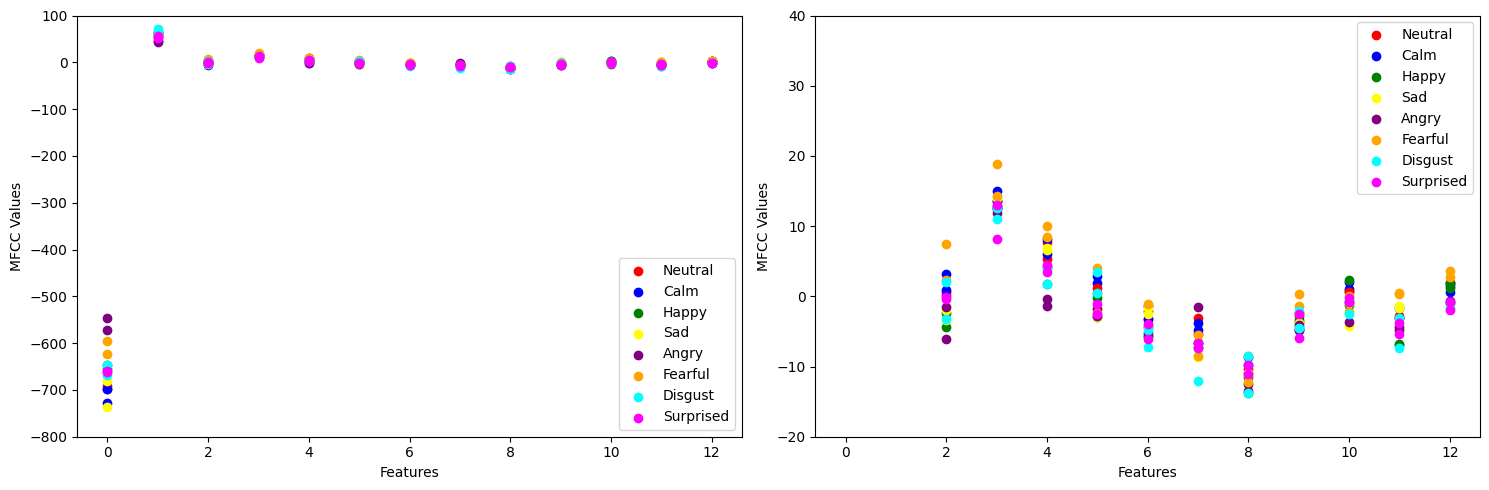

In [ ]:
visualize_by_statement(data_path, intensity='01', repetition='01', actor='01')

In the left figure, we see the distribution of the MFCC values of different emotions based on the number of features. We could observe some patterns at the first featre, with angry emotion having the highest values, fearful next, surprised and disgust in the middle, and sad and calm having lower values. Figure 2 changes the range of MFCC to look at so we could find some patterns in other features. Relatively similar patterns like shown in the first feature are observed. As a result, this data exploration exhibits some pattern that we could eye ball, setting an intuitive basis for our subsequent classification training.

# Model Training
We trained several different Convolutional Neural Networks (CNN) on our data. We altered the dimensions of and number of features in our data:
- First, we trained a few 1D CNNs, fed with 13 MFCC features averaged across time. 
- Then, we tried 1D CNNs with 30 MFCC features averaged across time. 
- Finally, we tried 2D CNNs that take in 30 MFCC features at different time frames.

Before defining the models, we built `Dataloader`s and our training and testing loops.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torchsummary import summary
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
# transform preprocessed data to Dataset class
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor

# transform arrays to torch tensors
X_train = Tensor(X_train).unsqueeze(1) # add channel = 1
y_train = Tensor(y_train)
X_test = Tensor(X_test).unsqueeze(1) # add channel = 1
y_test = Tensor(y_test)

train_set = TensorDataset(X_train, y_train) 
test_set = TensorDataset(X_test, y_test) 

In [ ]:
X_train.shape

torch.Size([1152, 1, 13])

In [ ]:
# create DataLoaders
batch_size = 16

train_loader = DataLoader(train_set, batch_size = batch_size, 
                          shuffle = True, num_workers = 2)
test_loader = DataLoader(test_set, batch_size = batch_size, 
                          shuffle = True, num_workers = 2)

In [ ]:
X, y = next(iter(train_loader))
print(X.shape, y.shape) 

torch.Size([16, 1, 13]) torch.Size([16, 8])


In our training loop, we used cross entropy loss as the loss function, Adam as the optimizer, and a learning rate of 0.001. 

In [ ]:
# training loop
import torch.optim as optim
train_history = []
test_history = []

def train(model, k_epochs = 1, print_every = 40):

    loss_fn = nn.CrossEntropyLoss() 
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    correct, total, accuracy = 0, 0, 0

    for epoch in range(k_epochs): 

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):

            # extract a batch of training data from the data loader
            X, y = data
            X = X.to(device)
            y = y.to(device)

            # zero out gradients: we're going to recompute them in a moment
            optimizer.zero_grad()

            # compute the loss (forward pass)
            y_hat = model(X)
            loss = loss_fn(y_hat, y)

            # compute the gradient (backward pass)
            loss.backward()

            # Adam uses the gradient to update the parameters
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            # for printing accuracy
            total += y.size(0)
            correct += (torch.argmax(y_hat, dim=1) == torch.argmax(y, dim=1)).sum().item() # for one-hot labels
            #correct += (y_hat.argmax(1) == y).sum().item() # for integer labels
            accuracy = correct/total


            # print the epoch, number of batches processed, and running loss 
            # in regular intervals
            if i % print_every == print_every - 1:    
              print(f'[epoch: {epoch + 1}, batches: {i + 1:5d}], loss: {running_loss / print_every:.3f}, accuracy:{accuracy:.3f}')
              running_loss = 0.0
          
        # append accuracy for each epoch
        train_history.append(accuracy)

        with torch.no_grad():
          for i, data in enumerate(test_loader, 0):
            correct, total, accuracy = 0, 0, 0
            X, y = data
            X = X.to(device)
            y = y.to(device)
            
            y_hat = model(X)

            # the class with the largest model output is the prediction
            predicted = torch.argmax(y_hat, dim=1)

            # compute the accuracy
            total += y.size(0)
            correct += (torch.argmax(y_hat, dim=1) == torch.argmax(y, dim=1)).sum().item() # for one-hot labels
            #correct += (y_hat.argmax(1) == y).sum().item() # for integer labels
            accuracy = correct/total
            
        test_history.append(accuracy)


    print('Finished Training')



Our testing loop is quite similar to what we wrote in class.

In [ ]:
# testing loop
def test(model, data_loader):
    correct, total = 0, 0
    
    # torch.no_grad creates an environment in which we do NOT store the 
    # computational graph. We don't need to do this because we don't care about 
    # gradients unless we're training
    with torch.no_grad():
        for data in data_loader:
            X, y = data
            X = X.to(device)
            y = y.to(device)
            
            y_hat = model(X)

            # the class with the largest model output is the prediction
            predicted = torch.argmax(y_hat, dim=1)

            # compute the accuracy
            total += y.size(0)
            correct += (torch.argmax(y_hat, dim=1) == torch.argmax(y, dim=1)).sum().item() # for one-hot labels
            #correct += (y_hat.argmax(1) == y).sum().item() # for integer labels

    print(f'Test accuracy: {100 * correct // total} %')


## 1D CNN + 13 MFCCs
We first trained three 1D CNNs on 13 MFCC features.

In [ ]:
# model 1: 2 conv layers, 2 fc layers
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv1d(1, 32, kernel_size=3)
    self.bn1 = nn.BatchNorm1d(32)
    self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
    self.bn2 = nn.BatchNorm1d(64)
    self.pool = nn.MaxPool1d(2)
    self.fc1 = nn.Linear(64, 128)
    self.fc2 = nn.Linear(128, 8)
  
  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = torch.flatten(x, 1) 
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

model1 = ConvNet().to(device)

In [ ]:
# train model1
train_history = []
test_history = []
train(model1, k_epochs = 30)

[epoch: 1, batches:    40], loss: 1.999, accuracy:0.192
[epoch: 2, batches:    40], loss: 1.853, accuracy:0.277
[epoch: 3, batches:    40], loss: 1.769, accuracy:0.338
[epoch: 4, batches:    40], loss: 1.726, accuracy:0.325
[epoch: 5, batches:    40], loss: 1.678, accuracy:0.364
[epoch: 6, batches:    40], loss: 1.671, accuracy:0.360
[epoch: 7, batches:    40], loss: 1.627, accuracy:0.351
[epoch: 8, batches:    40], loss: 1.589, accuracy:0.392
[epoch: 9, batches:    40], loss: 1.588, accuracy:0.383
[epoch: 10, batches:    40], loss: 1.551, accuracy:0.415
[epoch: 11, batches:    40], loss: 1.554, accuracy:0.419
[epoch: 12, batches:    40], loss: 1.528, accuracy:0.405
[epoch: 13, batches:    40], loss: 1.498, accuracy:0.415
[epoch: 14, batches:    40], loss: 1.514, accuracy:0.402
[epoch: 15, batches:    40], loss: 1.488, accuracy:0.433
[epoch: 16, batches:    40], loss: 1.448, accuracy:0.439
[epoch: 17, batches:    40], loss: 1.483, accuracy:0.444
[epoch: 18, batches:    40], loss: 1.443

In [ ]:
# test model1
test(model1, test_loader)

Test accuracy: 42 %


In [ ]:
# visualize testing vs. training accuracy
import matplotlib.pyplot as plt

def plot_accuracy(train_history, test_history, k_epochs):
    # Create figure and axis objects
    fig, ax = plt.subplots()

    # Plot the training and validation accuracy curves
    ax.plot(np.arange(k_epochs)+1, train_history, label='Training Accuracy')
    ax.plot(np.arange(k_epochs)+1, test_history, label='Validation Accuracy')

    # Set axis labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training and Validation Accuracy')

    # Set axis limits and ticks
    ax.set_ylim([0, 1])
    ax.set_xticks(np.arange(1, k_epochs+1, 3))

    # Add legend
    ax.legend()

    # Show plot
    plt.show()

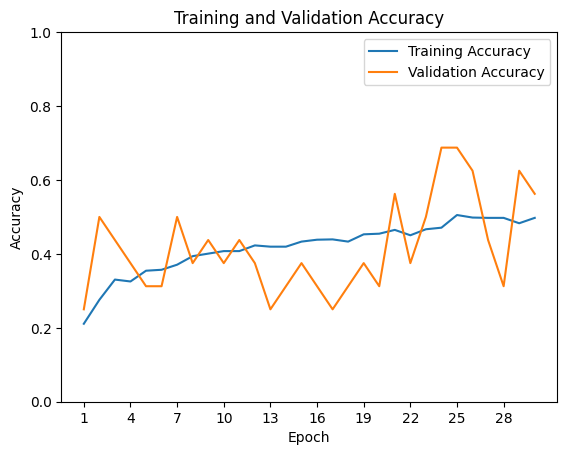

In [ ]:
plot_accuracy(train_history, test_history, 30)

In [ ]:
# model 2: 2 conv layers, 3 fc layers
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv1d(1, 32, kernel_size=3)
    self.bn1 = nn.BatchNorm1d(32)
    self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
    self.bn2 = nn.BatchNorm1d(64)
    self.pool = nn.MaxPool1d(2)
    self.fc1 = nn.Linear(64, 32)
    self.fc2 = nn.Linear(32, 16)
    self.fc3 = nn.Linear(16, 8)
  
  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = torch.flatten(x, 1) 
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model2 = ConvNet().to(device)

In [ ]:
train_history, test_history = [], []
train(model2, k_epochs = 30)

[epoch: 1, batches:    40], loss: 2.051, accuracy:0.164
[epoch: 2, batches:    40], loss: 1.949, accuracy:0.247
[epoch: 3, batches:    40], loss: 1.864, accuracy:0.259
[epoch: 4, batches:    40], loss: 1.780, accuracy:0.309
[epoch: 5, batches:    40], loss: 1.753, accuracy:0.340
[epoch: 6, batches:    40], loss: 1.716, accuracy:0.346
[epoch: 7, batches:    40], loss: 1.676, accuracy:0.367
[epoch: 8, batches:    40], loss: 1.641, accuracy:0.370
[epoch: 9, batches:    40], loss: 1.622, accuracy:0.370
[epoch: 10, batches:    40], loss: 1.619, accuracy:0.366
[epoch: 11, batches:    40], loss: 1.596, accuracy:0.410
[epoch: 12, batches:    40], loss: 1.598, accuracy:0.392
[epoch: 13, batches:    40], loss: 1.564, accuracy:0.425
[epoch: 14, batches:    40], loss: 1.584, accuracy:0.401
[epoch: 15, batches:    40], loss: 1.527, accuracy:0.448
[epoch: 16, batches:    40], loss: 1.522, accuracy:0.418
[epoch: 17, batches:    40], loss: 1.544, accuracy:0.389
[epoch: 18, batches:    40], loss: 1.542

In [ ]:
test(model2, test_loader)

Test accuracy: 40 %


## 1D CNN + 30 MFCCs
Then, we trained the 1D CNN models with 30 MFCCs.



In [ ]:
# train-test-split and dataloaders for 30 mfccs

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_more_mfcc, y, test_size=0.2, random_state=0)

In [ ]:
# transform arrays to torch tensors
X_train = Tensor(X_train).unsqueeze(1) # add channel = 1
y_train = Tensor(y_train)
X_test = Tensor(X_test).unsqueeze(1) # add channel = 1
y_test = Tensor(y_test)

train_set = TensorDataset(X_train, y_train) 
test_set = TensorDataset(X_test, y_test) 

In [ ]:
# create DataLoaders
batch_size = 16

train_loader = DataLoader(train_set, batch_size = batch_size, 
                          shuffle = True, num_workers = 2)
test_loader = DataLoader(test_set, batch_size = batch_size, 
                          shuffle = True, num_workers = 2)

In [ ]:
# model 4
class ConvNet(nn.Module):
    def __init__(self, input_len):
        super().__init__()

        self.conv1 = nn.Conv1d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(64 * (((input_len - 2) // 2 - 2) // 2), 128)
        self.fc2 = nn.Linear(128, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_len = 30  # input_len is the n_mfcc
model4 = ConvNet(input_len).to(device)

In [ ]:
train_history, test_history = [], []
train(model4, k_epochs = 30)

[epoch: 1, batches:    40], loss: 1.989, accuracy:0.205
[epoch: 2, batches:    40], loss: 1.753, accuracy:0.325
[epoch: 3, batches:    40], loss: 1.631, accuracy:0.395
[epoch: 4, batches:    40], loss: 1.506, accuracy:0.444
[epoch: 5, batches:    40], loss: 1.374, accuracy:0.511
[epoch: 6, batches:    40], loss: 1.279, accuracy:0.534
[epoch: 7, batches:    40], loss: 1.194, accuracy:0.582
[epoch: 8, batches:    40], loss: 1.098, accuracy:0.602
[epoch: 9, batches:    40], loss: 1.066, accuracy:0.619
[epoch: 10, batches:    40], loss: 0.965, accuracy:0.662
[epoch: 11, batches:    40], loss: 0.880, accuracy:0.675
[epoch: 12, batches:    40], loss: 0.827, accuracy:0.712
[epoch: 13, batches:    40], loss: 0.806, accuracy:0.707
[epoch: 14, batches:    40], loss: 0.728, accuracy:0.739
[epoch: 15, batches:    40], loss: 0.652, accuracy:0.782
[epoch: 16, batches:    40], loss: 0.686, accuracy:0.759
[epoch: 17, batches:    40], loss: 0.580, accuracy:0.799
[epoch: 18, batches:    40], loss: 0.518

In [ ]:
test(model4, test_loader)

Test accuracy: 64 %


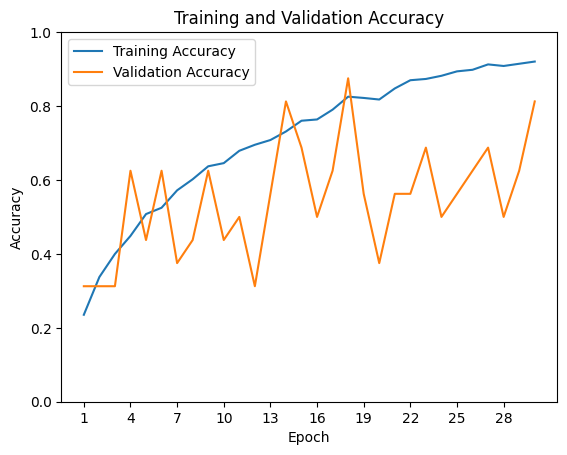

In [ ]:
plot_accuracy(train_history, test_history, 30)

In [ ]:
# model5
class ConvNet(nn.Module):
  def __init__(self, input_len):
    super().__init__()

    self.conv1 = nn.Conv1d(1, 32, kernel_size=3)
    self.bn1 = nn.BatchNorm1d(32)
    self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
    self.bn2 = nn.BatchNorm1d(64)
    self.pool = nn.MaxPool1d(2)
    self.fc1 = nn.Linear(64 * (((input_len - 2) // 2 - 2) // 2), 32)
    self.fc2 = nn.Linear(32, 16)
    self.fc3 = nn.Linear(16, 8)
  
  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = torch.flatten(x, 1) 
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model5 = ConvNet(input_len).to(device)

In [ ]:
train_history, test_history = [], []
train(model5, k_epochs = 30)

[epoch: 1, batches:    40], loss: 2.054, accuracy:0.188
[epoch: 2, batches:    40], loss: 1.935, accuracy:0.238
[epoch: 3, batches:    40], loss: 1.867, accuracy:0.258
[epoch: 4, batches:    40], loss: 1.786, accuracy:0.320
[epoch: 5, batches:    40], loss: 1.656, accuracy:0.363
[epoch: 6, batches:    40], loss: 1.658, accuracy:0.377
[epoch: 7, batches:    40], loss: 1.510, accuracy:0.450
[epoch: 8, batches:    40], loss: 1.457, accuracy:0.468
[epoch: 9, batches:    40], loss: 1.380, accuracy:0.491
[epoch: 10, batches:    40], loss: 1.297, accuracy:0.527
[epoch: 11, batches:    40], loss: 1.260, accuracy:0.541
[epoch: 12, batches:    40], loss: 1.304, accuracy:0.520
[epoch: 13, batches:    40], loss: 1.177, accuracy:0.562
[epoch: 14, batches:    40], loss: 1.122, accuracy:0.588
[epoch: 15, batches:    40], loss: 1.100, accuracy:0.604
[epoch: 16, batches:    40], loss: 1.024, accuracy:0.605
[epoch: 17, batches:    40], loss: 0.995, accuracy:0.627
[epoch: 18, batches:    40], loss: 0.995

In [ ]:
test(model5, test_loader)

Test accuracy: 61 %


In [ ]:
# model6
class EmotionClassifierCNN(nn.Module):
    def __init__(self, num_classes, input_len):
        super(EmotionClassifierCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        
        output_size = input_len // (2 * 2 * 2)  # Divide by 2 for each pooling layer
        self.fc1 = nn.Linear(64 * output_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_len = X_train.shape[2]
num_classes = y_train.shape[1]
model6 = EmotionClassifierCNN(num_classes, input_len).to(device)

In [ ]:
train(model6, k_epochs = 30)

[epoch: 1, batches:    40], loss: 2.039, accuracy:0.181
[epoch: 2, batches:    40], loss: 1.822, accuracy:0.268
[epoch: 3, batches:    40], loss: 1.787, accuracy:0.302
[epoch: 4, batches:    40], loss: 1.632, accuracy:0.392
[epoch: 5, batches:    40], loss: 1.626, accuracy:0.381
[epoch: 6, batches:    40], loss: 1.539, accuracy:0.413
[epoch: 7, batches:    40], loss: 1.467, accuracy:0.434
[epoch: 8, batches:    40], loss: 1.444, accuracy:0.462
[epoch: 9, batches:    40], loss: 1.459, accuracy:0.453
[epoch: 10, batches:    40], loss: 1.359, accuracy:0.514
[epoch: 11, batches:    40], loss: 1.297, accuracy:0.526
[epoch: 12, batches:    40], loss: 1.256, accuracy:0.512
[epoch: 13, batches:    40], loss: 1.209, accuracy:0.534
[epoch: 14, batches:    40], loss: 1.184, accuracy:0.552
[epoch: 15, batches:    40], loss: 1.104, accuracy:0.579
[epoch: 16, batches:    40], loss: 1.128, accuracy:0.584
[epoch: 17, batches:    40], loss: 1.071, accuracy:0.585
[epoch: 18, batches:    40], loss: 1.036

In [ ]:
test(model6, test_loader)

Test accuracy: 57 %


## 2D CNN + 30 MFCCs
Next, we trained 2D CNN models on 30 MFCCs.

In [ ]:
X_2d_new = np.load('/content/drive/MyDrive/speech-emotion-recognition/X_2d.npy')
y = np.load('/content/drive/MyDrive/speech-emotion-recognition/y.npy')
print(X_2d_new.shape, y.shape)

(1440, 30, 144) (1440, 8)


In [ ]:
# train-test-split and dataloaders for 2d features

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_2d, y, test_size=0.2, random_state=0)

In [ ]:
# transform arrays to torch tensors
X_train = Tensor(X_train).unsqueeze(1) # add channel = 1
y_train = Tensor(y_train)
X_test = Tensor(X_test).unsqueeze(1) # add channel = 1
y_test = Tensor(y_test)

train_set = TensorDataset(X_train, y_train) 
test_set = TensorDataset(X_test, y_test) 

In [ ]:
# create DataLoaders
batch_size = 16

train_loader = DataLoader(train_set, batch_size = batch_size, 
                          shuffle = True, num_workers = 2)
test_loader = DataLoader(test_set, batch_size = batch_size, 
                          shuffle = True, num_workers = 2)

In [ ]:
# model 1: 2 conv layers, 2 fc layers
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 128, kernel_size=3)
    self.bn1 = nn.BatchNorm2d(128)
    self.conv2 = nn.Conv2d(128, 64, kernel_size=3)
    self.bn2 = nn.BatchNorm2d(64)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 204, 32)
    self.fc2 = nn.Linear(32, 8)
  
  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

model1 = ConvNet().to(device)

In [ ]:
# train model1
train_history, test_history = [], []
train(model1, k_epochs = 30)

[epoch: 1, batches:    40], loss: 2.144, accuracy:0.166
[epoch: 2, batches:    40], loss: 1.796, accuracy:0.258
[epoch: 3, batches:    40], loss: 1.626, accuracy:0.355
[epoch: 4, batches:    40], loss: 1.494, accuracy:0.422
[epoch: 5, batches:    40], loss: 1.402, accuracy:0.441
[epoch: 6, batches:    40], loss: 1.393, accuracy:0.438
[epoch: 7, batches:    40], loss: 1.198, accuracy:0.514
[epoch: 8, batches:    40], loss: 1.202, accuracy:0.498
[epoch: 9, batches:    40], loss: 1.088, accuracy:0.555
[epoch: 10, batches:    40], loss: 0.979, accuracy:0.611
[epoch: 11, batches:    40], loss: 0.968, accuracy:0.622
[epoch: 12, batches:    40], loss: 0.849, accuracy:0.649
[epoch: 13, batches:    40], loss: 0.769, accuracy:0.707
[epoch: 14, batches:    40], loss: 0.596, accuracy:0.787
[epoch: 15, batches:    40], loss: 0.542, accuracy:0.780
[epoch: 16, batches:    40], loss: 0.452, accuracy:0.848
[epoch: 17, batches:    40], loss: 0.412, accuracy:0.867
[epoch: 18, batches:    40], loss: 0.316

In [ ]:
# test model1
test(model1, test_loader)

Test accuracy: 53 %


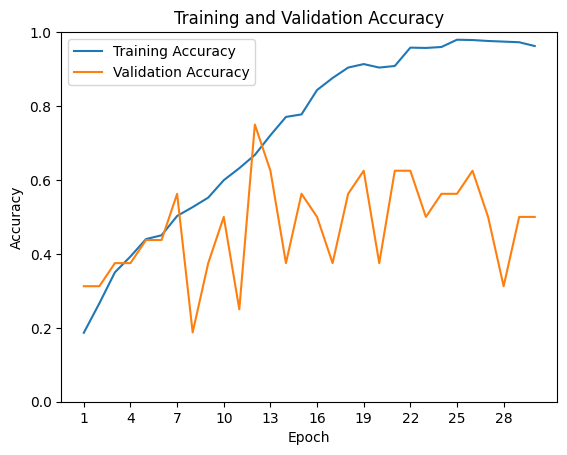

In [ ]:
plot_accuracy(train_history, test_history, 30)

In [ ]:
# model 2: with dropout
class ConvNet(nn.Module):
  def __init__(self, dropout_prob = 0.5):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 128, kernel_size=3)
    self.bn1 = nn.BatchNorm2d(128)
    self.conv2 = nn.Conv2d(128, 64, kernel_size=3)
    self.bn2 = nn.BatchNorm2d(64)
    self.dropout = nn.Dropout(dropout_prob)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 204, 32)
    self.fc2 = nn.Linear(32, 8)
  
  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.dropout(x)
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.dropout(x)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

model2 = ConvNet().to(device)

In [ ]:
train_history, test_history = [], []
train(model2, k_epochs = 30)

[epoch: 1, batches:    40], loss: 2.194, accuracy:0.150
[epoch: 2, batches:    40], loss: 2.076, accuracy:0.155
[epoch: 3, batches:    40], loss: 2.077, accuracy:0.127
[epoch: 4, batches:    40], loss: 2.074, accuracy:0.123
[epoch: 5, batches:    40], loss: 2.071, accuracy:0.133
[epoch: 6, batches:    40], loss: 2.064, accuracy:0.128
[epoch: 7, batches:    40], loss: 2.070, accuracy:0.117
[epoch: 8, batches:    40], loss: 2.063, accuracy:0.142
[epoch: 9, batches:    40], loss: 2.060, accuracy:0.123
[epoch: 10, batches:    40], loss: 2.064, accuracy:0.122
[epoch: 11, batches:    40], loss: 2.061, accuracy:0.140
[epoch: 12, batches:    40], loss: 2.063, accuracy:0.134
[epoch: 13, batches:    40], loss: 2.066, accuracy:0.127
[epoch: 14, batches:    40], loss: 2.059, accuracy:0.139
[epoch: 15, batches:    40], loss: 2.060, accuracy:0.137
[epoch: 16, batches:    40], loss: 2.061, accuracy:0.137
[epoch: 17, batches:    40], loss: 2.061, accuracy:0.128
[epoch: 18, batches:    40], loss: 2.051

In [ ]:
test(model2, test_loader)

Test accuracy: 10 %


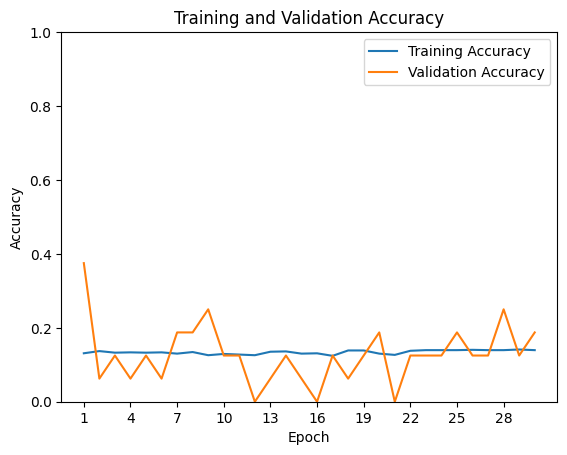

In [ ]:
plot_accuracy(train_history, test_history, 30)

In [ ]:
# model 3: with dropout, different linear layers
class ConvNet(nn.Module):
  def __init__(self, dropout_prob = 0.5):
    super().__init__()

    self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
    self.bn1 = nn.BatchNorm2d(64)
    self.conv2 = nn.Conv2d(64, 32, kernel_size=3)
    self.bn2 = nn.BatchNorm2d(32)
    self.dropout = nn.Dropout(dropout_prob)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 102, 128)
    self.fc2 = nn.Linear(128, 8)
  
  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.dropout(x)
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = self.dropout(x)
    x = x.view(x.size(0), -1)
    x = F.relu(self.fc1(x))

    x = self.fc2(x)
    return x

model3 = ConvNet().to(device)

In [ ]:
train_history, test_history = [], []
train(model3, k_epochs = 30)

[epoch: 1, batches:    40], loss: 1.616, accuracy:0.375
[epoch: 2, batches:    40], loss: 1.557, accuracy:0.398
[epoch: 3, batches:    40], loss: 1.333, accuracy:0.498
[epoch: 4, batches:    40], loss: 1.336, accuracy:0.488
[epoch: 5, batches:    40], loss: 1.286, accuracy:0.494
[epoch: 6, batches:    40], loss: 1.145, accuracy:0.566
[epoch: 7, batches:    40], loss: 1.074, accuracy:0.591
[epoch: 8, batches:    40], loss: 0.978, accuracy:0.634
[epoch: 9, batches:    40], loss: 0.900, accuracy:0.660
[epoch: 10, batches:    40], loss: 0.817, accuracy:0.697
[epoch: 11, batches:    40], loss: 0.752, accuracy:0.723
[epoch: 12, batches:    40], loss: 0.723, accuracy:0.742
[epoch: 13, batches:    40], loss: 0.667, accuracy:0.755
[epoch: 14, batches:    40], loss: 0.631, accuracy:0.758
[epoch: 15, batches:    40], loss: 0.610, accuracy:0.765
[epoch: 16, batches:    40], loss: 0.602, accuracy:0.765
[epoch: 17, batches:    40], loss: 0.483, accuracy:0.825
[epoch: 18, batches:    40], loss: 0.535

In [ ]:
test(model3, test_loader)

Test accuracy: 59 %


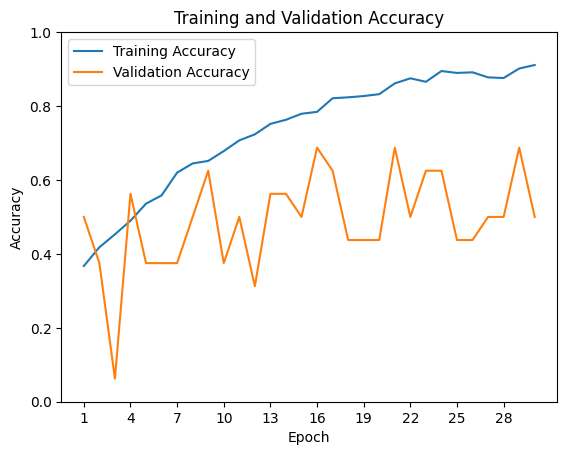

In [ ]:
plot_accuracy(train_history, test_history, 30)